# Applied ML: HW2

## Partners: Ajinkya Pawale, Maazin Jawad
## Grade Maazin Jawad's submission (mjawad@Iu.edu) 

In [1]:
import math
import numpy as np
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from collections import Counter

data = pd.read_csv("message.csv")
data.info()
print("\n", data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Label    5572 non-null   int64 
 1   Message  5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB

    Label                                            Message
0      0  go until jurong point  crazy   available only ...
1      0                      ok lar    joking wif u oni   
2      1  free entry in 2 a wkly comp to win fa cup fina...
3      0  u dun say so early hor    u c already then say   
4      0  nah i don t think he goes to usf  he lives aro...


## Data Preparation and Split

In [2]:
#shuffle the data
data = utils.shuffle(data)
data.reset_index(inplace=True, drop = True)
print("\n", data.head())

#80-20 split for list of size 5572
TRAIN = data.iloc[0:4459, 0:2]
TEST = data.iloc[4459:5572, 0:2]


print("\n", TRAIN.info())
print("\n", TEST.info())


    Label                                            Message
0      0                                             yup   
1      0                      oh is it  send me the address
2      0                  long time  you remember me today 
3      0  allo  we have braved the buses and taken on th...
4      0         no just send to you  bec you in temple na 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4459 entries, 0 to 4458
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Label    4459 non-null   int64 
 1   Message  4459 non-null   object
dtypes: int64(1), object(1)
memory usage: 69.8+ KB

 None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1113 entries, 4459 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Label    1113 non-null   int64 
 1   Message  1113 non-null   object
dtypes: int64(1), object(1)
memory usage: 17.5+ KB

 None


## Construct Vocabulary and Frequency Table

In [3]:
def getVocab(train):
    vocab = set()
    messages = train["Message"]
    for message in messages:
        wordsInMessage = message.split()
        vocab = vocab.union(set(wordsInMessage))
    len(vocab)
    vocab = list(vocab)
    return vocab


In [4]:

def getFrequencyTable(train, vocab):
    messages = train["Message"]

    messageCounts = pd.DataFrame(0, columns=vocab, index=range(0, len(messages)))

    for mindex, message in enumerate(messages):
        wordsInMessage = message.split()
        for word in wordsInMessage:
            timesWordAppearsInMessage = wordsInMessage.count(word)
            messageCounts.loc[mindex, word] = timesWordAppearsInMessage
    return messageCounts



## Conditional Probabilities

In [5]:
def getConditionalProbabilities(train, messageCounts):

    messageCounts["sum"] = messageCounts.sum(axis=1)

    ones = messageCounts[train["Label"]==1]
    zeroes = messageCounts[train["Label"]==0]

    numberOfZeroes = np.sum(ones["sum"])
    numberOfOnes = np.sum(zeroes["sum"])

    prob1 = numberOfOnes/(numberOfZeroes+numberOfOnes)
    prob0 = numberOfZeroes/(numberOfZeroes+numberOfOnes)


    conditionalProbsForClass1 = {}
    conditionalProbsForClass0 = {}

    colSums1 =  ones.sum(axis=0)/numberOfOnes
    colSums0 = zeroes.sum(axis=0)/numberOfZeroes

    words = messageCounts.columns
    for index,word in enumerate(words):
        conditionalProbsForClass0[word] = colSums0[index]
        conditionalProbsForClass1[word] = colSums1[index]

    return {"prior1":prob1, "prior0":prob0, "conditionalProbsForClass1": conditionalProbsForClass1, "conditionalProbsForClass0":conditionalProbsForClass0 }




## Prediction and Evaluation 

In [6]:

def predict(train, test,vocab):
    messageCounts = getFrequencyTable(train, vocab)
    priorAndConditionalDict = getConditionalProbabilities(train, messageCounts)
    prior1 = priorAndConditionalDict["prior1"]
    prior0 = priorAndConditionalDict["prior0"]
    conditionalProbsForClass1 = priorAndConditionalDict["conditionalProbsForClass1"]
    conditionalProbsForClass0 = priorAndConditionalDict["conditionalProbsForClass0"]
    predictions = []
    for mindex, message in enumerate(test["Message"]):
        words = message.split()
        pClass1GivenMessage = 1
        pClass0GivenMessage = 1
        for word in words:
            if(word in conditionalProbsForClass1):
                pClass1GivenMessage = pClass1GivenMessage * conditionalProbsForClass1[word]
                pClass0GivenMessage = pClass0GivenMessage * conditionalProbsForClass0[word]
            

        likelihood1 = prior1 * pClass1GivenMessage
        likelihood0 = prior0 * pClass0GivenMessage
        prediction = 0
        if (likelihood1 > likelihood0):
            prediction = 1
        predictions.append(prediction)
    return predictions



In [7]:
skf = KFold(10)

from sklearn.metrics import confusion_matrix


model = 1
averageAccuracy = 0
averagePrecision = 0
averageRecall = 0
averageSpecificity = 0

for train_index, test_index in skf.split(TRAIN):
    train = TRAIN.iloc[train_index]
    train.reset_index(inplace=True, drop = True)
    test = TRAIN.iloc[test_index]
    test.reset_index(inplace=True, drop = True)
    vocab = getVocab(train)
    predictions = predict(train,test,vocab)
    tn, fp, fn, tp = confusion_matrix(test["Label"], predictions).ravel()


    print("\nModel ", model, " Evaluation")
    print("================================")
    print("True Negative (Guess Not Spam When Not Spam): ", tn)
    print("False Positive (Guess Spam When Not Spam): ", fp)
    print("False Negative (Guess Not Spam When Spam): ", fn)
    print("True Positive (Guess Spam When Spam): ", tp)

    accuracy = ((tn + tp) / (tp + tn + fn + fp))
    precision = (tp / (tp + fp))
    recall = (tp/(tp+fn))
    specificity = (tn/(tn+fp))

    print("Accuracy: ", round(accuracy,2)*100, "%")
    print("Precision: ", round(precision,2)*100, "%")
    print("Recall: ", round(recall,2)*100, "%")
    print("Specificity: ", round(specificity,2)*100, "%")

    averageAccuracy = averageAccuracy + accuracy / 10
    averagePrecision = averagePrecision + precision / 10
    averageRecall = averageRecall + recall / 10
    averageSpecificity = averageSpecificity + specificity / 10

    model = model + 1

print("\nAverage Performance Across All Folds")

print("Average Accuracy: ", round(averageAccuracy,2)*100, "%")
print("Average Precision: ", round(averagePrecision,2)*100, "%")
print("Average Recall: ", round(averageRecall,2)*100, "%")
print("Average Specificity: ", round(averageSpecificity,2)*100, "%")




Model  1  Evaluation
True Negative (Guess Not Spam When Not Spam):  374
False Positive (Guess Spam When Not Spam):  2
False Negative (Guess Not Spam When Spam):  20
True Positive (Guess Not Spam When Spam):  50
Accuracy:  95.0 %
Precision:  96.0 %
Recall:  71.0 %
Specificity:  99.0 %

Model  2  Evaluation
True Negative (Guess Not Spam When Not Spam):  385
False Positive (Guess Spam When Not Spam):  1
False Negative (Guess Not Spam When Spam):  19
True Positive (Guess Not Spam When Spam):  41
Accuracy:  96.0 %
Precision:  98.0 %
Recall:  68.0 %
Specificity:  100.0 %

Model  3  Evaluation
True Negative (Guess Not Spam When Not Spam):  394
False Positive (Guess Spam When Not Spam):  0
False Negative (Guess Not Spam When Spam):  16
True Positive (Guess Not Spam When Spam):  36
Accuracy:  96.0 %
Precision:  100.0 %
Recall:  69.0 %
Specificity:  100.0 %

Model  4  Evaluation
True Negative (Guess Not Spam When Not Spam):  385
False Positive (Guess Spam When Not Spam):  4
False Negative (Gues

In [8]:

def getConditionalProbabilitiesLaplacian(train, messageCounts):
    messageCounts["sum"] = messageCounts.sum(axis=1)

    ones = messageCounts[train["Label"] == 1]
    zeroes = messageCounts[train["Label"] == 0]

    numberOfZeroes = np.sum(ones["sum"])
    numberOfOnes = np.sum(zeroes["sum"])

    prob1 = numberOfOnes / (numberOfZeroes + numberOfOnes)
    prob0 = numberOfZeroes / (numberOfZeroes + numberOfOnes)

    conditionalProbsForClass1 = {}
    conditionalProbsForClass0 = {}

    words = messageCounts.columns
    colSums1 = ones.sum(axis=0) + 1 / (numberOfOnes + len(words))
    colSums0 = zeroes.sum(axis=0) + 1 / (numberOfZeroes + len(words))

    for index, word in enumerate(words):
        conditionalProbsForClass0[word] = colSums0[index]
        conditionalProbsForClass1[word] = colSums1[index]

    return {"prior1": prob1, "prior0": prob0, "conditionalProbsForClass1": conditionalProbsForClass1,
            "conditionalProbsForClass0": conditionalProbsForClass0}

## Laplacian Smoothing Model

In [9]:

def predictLaplacian(train, test,vocab):
    messageCounts = getFrequencyTable(train, vocab)
    priorAndConditionalDict = getConditionalProbabilitiesLaplacian(train, messageCounts)
    prior1 = priorAndConditionalDict["prior1"]
    prior0 = priorAndConditionalDict["prior0"]
    conditionalProbsForClass1 = priorAndConditionalDict["conditionalProbsForClass1"]
    conditionalProbsForClass0 = priorAndConditionalDict["conditionalProbsForClass0"]
    predictions = []
    for mindex, message in enumerate(test["Message"]):
        words = message.split()
        pClass1GivenMessage = 1
        pClass0GivenMessage = 1
        for word in words:
              if(word in conditionalProbsForClass1):
                pClass1GivenMessage = pClass1GivenMessage * conditionalProbsForClass1[word]
                pClass0GivenMessage = pClass0GivenMessage * conditionalProbsForClass0[word]
            
        likelihood1 = prior1 * pClass1GivenMessage
        likelihood0 = prior0 * pClass0GivenMessage
        prediction = 0
        if (likelihood1 > likelihood0):
            prediction = 1
        predictions.append(prediction)
    return predictions

In [10]:

model = 1
averageAccuracy = 0
averagePrecision = 0
averageRecall = 0
averageSpecificity = 0

print("\nLAPLACIAN SMOOTHING MODEL")
print("======================")
print("======================")
for train_index, test_index in skf.split(TRAIN):
    train = TRAIN.iloc[train_index]
    train.reset_index(inplace=True, drop = True)
    test = TRAIN.iloc[test_index]
    test.reset_index(inplace=True, drop = True)
    vocab = getVocab(train)
    predictions = predictLaplacian(train,test,vocab)
    tn, fp, fn, tp = confusion_matrix(test["Label"], predictions).ravel()


    print("\nModel ", model, " Evaluation")
    print("================================")
    print("True Negative (Guess Not Spam When Not Spam): ", tn)
    print("False Positive (Guess Spam When Not Spam): ", fp)
    print("False Negative (Guess Not Spam When Spam): ", fn)
    print("True Positive (Guess Spam When Spam): ", tp)

    accuracy = ((tn + tp) / (tp + tn + fn + fp))
    precision = (tp / (tp + fp))
    recall = (tp/(tp+fn))
    specificity = (tn/(tn+fp))

    print("Accuracy: ", round(accuracy,2)*100, "%")
    print("Precision: ", round(precision,2)*100, "%")
    print("Recall: ", round(recall,2)*100, "%")
    print("Specificity: ", round(specificity,2)*100, "%")

    averageAccuracy = averageAccuracy + accuracy/10
    averagePrecision = averagePrecision + precision/10
    averageRecall = averageRecall + recall/10
    averageSpecificity = averageSpecificity + specificity/10

    model = model + 1

print("\nAverage Performance Across All Folds\n")

print("Average Accuracy: ", round(averageAccuracy,2)*100, "%")
print("Average Precision: ", round(averagePrecision,2)*100, "%")
print("Average Recall: ", round(averageRecall,2)*100, "%")
print("Average Specificity: ", round(averageSpecificity,2)*100, "%")





LAPLACIAN SMOOTHING MODEL

Model  1  Evaluation
True Negative (Guess Not Spam When Not Spam):  374
False Positive (Guess Spam When Not Spam):  2
False Negative (Guess Not Spam When Spam):  11
True Positive (Guess Not Spam When Spam):  59
Accuracy:  97.0 %
Precision:  97.0 %
Recall:  84.0 %
Specificity:  99.0 %

Model  2  Evaluation
True Negative (Guess Not Spam When Not Spam):  386
False Positive (Guess Spam When Not Spam):  0
False Negative (Guess Not Spam When Spam):  11
True Positive (Guess Not Spam When Spam):  49
Accuracy:  98.0 %
Precision:  100.0 %
Recall:  82.0 %
Specificity:  100.0 %


<ipython-input-9-b23b913f41d3>:16: RuntimeWarning: overflow encountered in double_scalars
  pClass0GivenMessage = pClass0GivenMessage * conditionalProbsForClass0[word]



Model  3  Evaluation
True Negative (Guess Not Spam When Not Spam):  394
False Positive (Guess Spam When Not Spam):  0
False Negative (Guess Not Spam When Spam):  9
True Positive (Guess Not Spam When Spam):  43
Accuracy:  98.0 %
Precision:  100.0 %
Recall:  83.0 %
Specificity:  100.0 %

Model  4  Evaluation
True Negative (Guess Not Spam When Not Spam):  385
False Positive (Guess Spam When Not Spam):  4
False Negative (Guess Not Spam When Spam):  13
True Positive (Guess Not Spam When Spam):  44
Accuracy:  96.0 %
Precision:  92.0 %
Recall:  77.0 %
Specificity:  99.0 %

Model  5  Evaluation
True Negative (Guess Not Spam When Not Spam):  393
False Positive (Guess Spam When Not Spam):  1
False Negative (Guess Not Spam When Spam):  10
True Positive (Guess Not Spam When Spam):  42
Accuracy:  98.0 %
Precision:  98.0 %
Recall:  81.0 %
Specificity:  100.0 %

Model  6  Evaluation
True Negative (Guess Not Spam When Not Spam):  382
False Positive (Guess Spam When Not Spam):  0
False Negative (Guess

In [11]:
##Update Vocab
vocab = set()
messages = data["Message"]
for message in messages:
    wordsInMessage = message.split()
    vocab = vocab.union(set(wordsInMessage))
len(vocab)
vocab = list(vocab)

In [12]:
print("\nFULL DATA EVALUATION\n")
predictions = predictLaplacian( TRAIN,TEST,vocab)
tn, fp, fn, tp = confusion_matrix(TEST["Label"], predictions).ravel()


print("Evaluation")
print("================================")
print("True Negative (Guess Not Spam When Not Spam): ", tn)
print("False Positive (Guess Spam When Not Spam): ", fp)
print("False Negative (Guess Not Spam When Spam): ", fn)
print("True Positive (Guess Spam When Spam): ", tp)

accuracy = ((tn + tp) / (tp + tn + fn + fp))
precision = (tp / (tp + fp))
recall = (tp/(tp+fn))
specificity = (tn/(tn+fp))

print("Accuracy: ", round(accuracy,2)*100, "%")
print("Precision: ", round(precision,2)*100, "%")
print("Recall: ", round(recall,2)*100, "%")
print("Specificity: ", round(specificity,2)*100, "%")


FULL DATA EVALUATION

Evaluation
True Negative (Guess Not Spam When Not Spam):  940
False Positive (Guess Spam When Not Spam):  4
False Negative (Guess Not Spam When Spam):  33
True Positive (Guess Not Spam When Spam):  136
Accuracy:  97.0 %
Precision:  97.0 %
Recall:  80.0 %
Specificity:  100.0 %


<ipython-input-9-b23b913f41d3>:16: RuntimeWarning: overflow encountered in double_scalars
  pClass0GivenMessage = pClass0GivenMessage * conditionalProbsForClass0[word]


## Commentary

First off, it is quite evident that laplacian smoothing enhanced the overall performance of our model, leading to a very significant increase in Recall percentage and almost perfect accuracy /precision in the Full Data model. 

Our KFold Cross Validation yielded remarkable statistics, indicating that our model would do well with new data (as was further evidenced with the full model). Note that stratified k-fold was implicitly carried out via the original shuffle applied to the data. 

Despite the "naive" assumption of independence between words showing up in a message, our model still yielded great results. The model is simple and straightforward, utilizing a fundamental rule of statistics to almost perfectly classify messages as Spam/Not Spam. 

# Part Two

In [6]:
df = pd.read_fwf('patient_satisfaction.txt', header=None, 
                    names=['satisfaction','age','severity','anxiety'])
df.head()

,satisfaction,age,severity,anxiety
0,48,50,51,2.3
1,57,36,46,2.3
2,66,40,48,2.2
3,70,41,44,1.8
4,89,28,43,1.8


### Normalizing the data, as there is difference between the ranges of the coefficients

In [7]:
df=(df-df.min())/(df.max()-df.min())
df.head()

,satisfaction,age,severity,anxiety
0,0.333333,0.848485,0.476190,0.454545
1,0.469697,0.424242,0.238095,0.454545
2,0.606061,0.545455,0.333333,0.363636
3,0.666667,0.575758,0.142857,0.000000
4,0.954545,0.181818,0.095238,0.000000


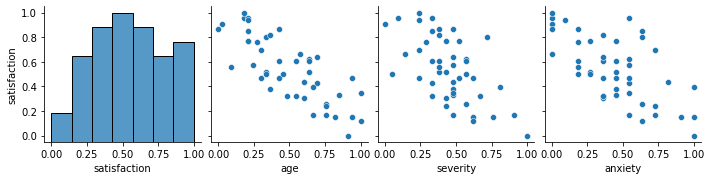

In [8]:
# Ref: https://seaborn.pydata.org/generated/seaborn.pairplot.html
import seaborn as sns
sns.pairplot(df, x_vars=["satisfaction","age","severity","anxiety"],y_vars="satisfaction")

### The scatter plots suggests that as the age, severity and anxiety values increase, there is a decrease in the satisfaction levels

In [6]:
corr_matrix=df2[["satisfaction","age","severity","anxiety"]].corr()
corr_matrix["satisfaction"].sort_values(ascending=False)

satisfaction    1.000000
severity       -0.602942
anxiety        -0.644591
age            -0.786756
Name: satisfaction, dtype: float64

### Reasoning:
### When the correlation coefficient is negative, it suggests that there is inverse correlation between the feature and label
### From the above scatter plots and correlation coefficient values it can be inferred that all the features namely "age", "severity" and "anxiety" in the dataset have negative correlation with the target label "satisfaction"

In [14]:
X = df[[i for i in df.columns if i != "satisfaction"]].to_numpy()
y = df["satisfaction"].to_numpy()

### Dividing the data into 10 splits using kfold method, so that the train test split can be evaluated for different folds

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
kf =KFold(n_splits=10)

### Batch Gradient Descent

#### Ref: https://towardsdatascience.com/gradient-descent-in-python-a0d07285742f

In [25]:
def gradient_descent(X,y,theta,learning_rate=0.01,iterations=10):
    m=len(y)
    cost_hist = np.zeros(iterations)
    theta_hist = np.zeros((iterations,4))
    for i in range(iterations):
        prediction=np.dot(X,theta)
        theta = theta - (1/m)*learning_rate*(X.T.dot((prediction-y)))
        theta_hist[i,:] = theta.T
        cost_hist[i] = cal_cost(theta,X,y)
    
    return theta, cost_hist,theta_hist

In [26]:
def cal_cost(theta,X,y):
    m=len(y)
    predictions = X.dot(theta)
    cost = (1/2*m) * np.sum(np.square(predictions-y))
    return cost

### For alpha = 0.1

Predictions for fold:1
Intercept value [0.94566711] 
weight values: [[-0.57674076]
 [ 0.03545613]
 [-0.31593318]]
Mean Square Error: 0.006 

Predictions for fold:2
Intercept value [0.91331532] 
weight values: [[-0.62601565]
 [ 0.2762219 ]
 [-0.40779865]]
Mean Square Error: 0.018 

Predictions for fold:3
Intercept value [0.9701018] 
weight values: [[-0.61035637]
 [-0.00683487]
 [-0.29164052]]
Mean Square Error: 0.053 

Predictions for fold:4
Intercept value [0.99051215] 
weight values: [[-0.50377876]
 [-0.21774958]
 [-0.25022239]]
Mean Square Error: 0.028 

Predictions for fold:5
Intercept value [1.03971401] 
weight values: [[-0.51456101]
 [-0.42927168]
 [-0.12451441]]
Mean Square Error: 0.013 

Predictions for fold:6
Intercept value [0.9786997] 
weight values: [[-0.59905933]
 [ 0.05727528]
 [-0.36596958]]
Mean Square Error: 0.033 

Predictions for fold:7
Intercept value [0.99821991] 
weight values: [[-0.54044493]
 [-0.14344361]
 [-0.26887412]]
Mean Square Error: 0.037 

Predictions for

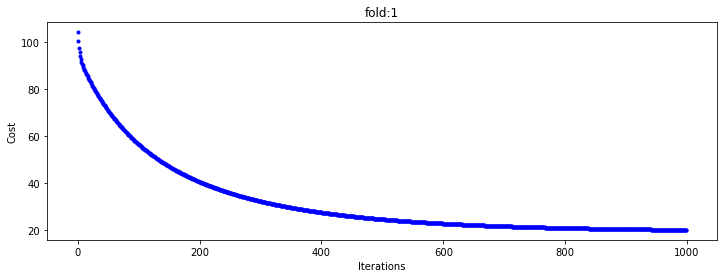

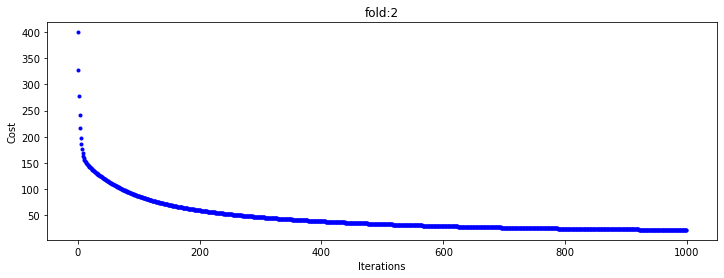

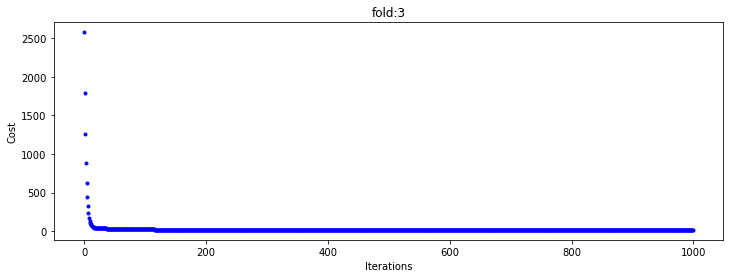

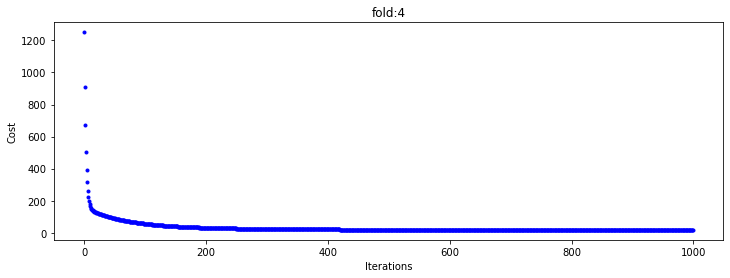

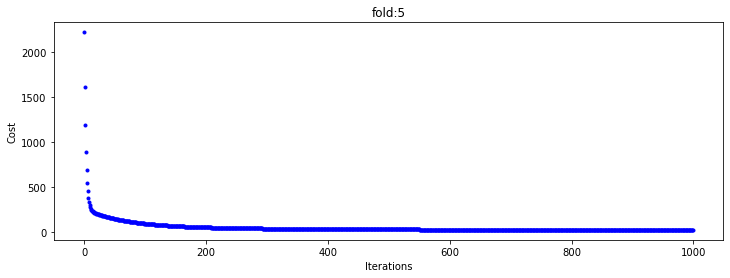

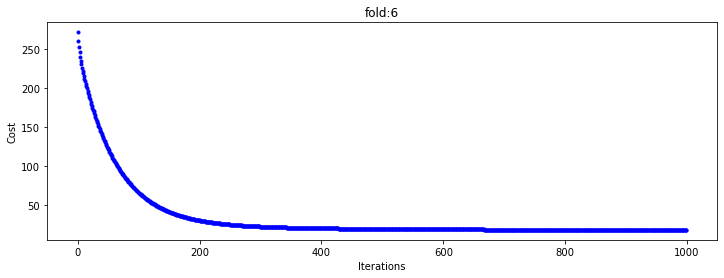

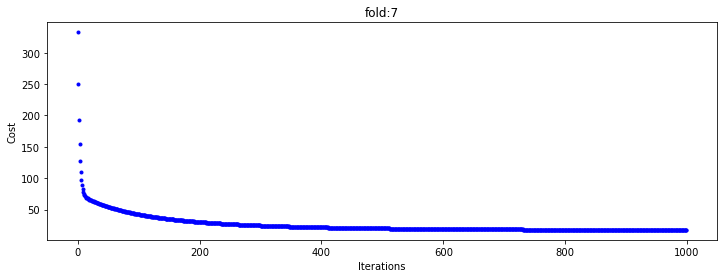

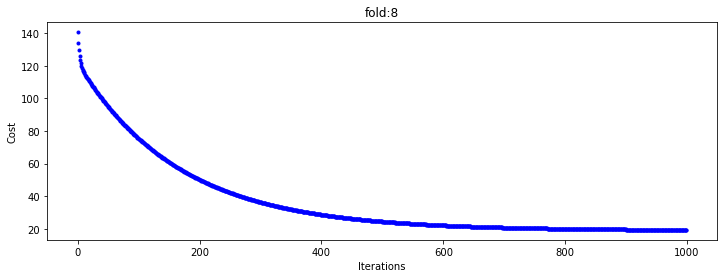

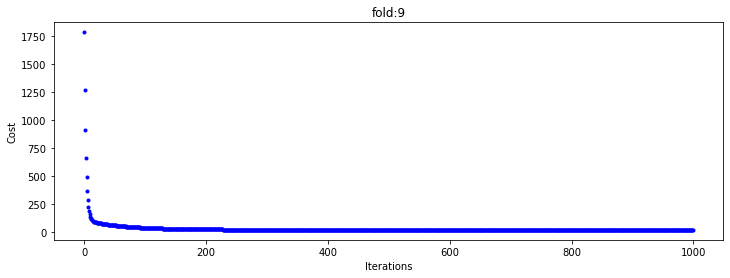

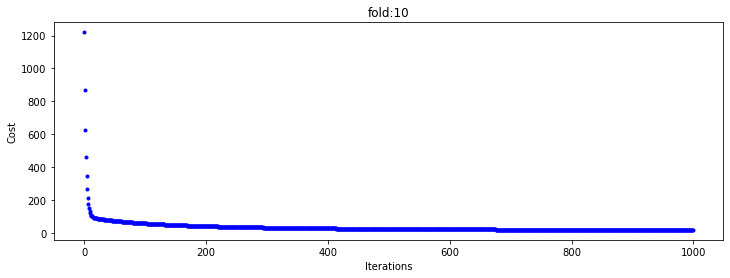

In [32]:
i=1
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index].reshape(-1,1), y[test_index].reshape(-1,1)
    X_train = np.c_[np.ones((len(X_train),1)),X_train]
    X_test = np.c_[np.ones((len(X_test),1)),X_test]
    lr = 0.1
    n_iter = 1000
    theta = np.random.randn(4, 1)
    theta, cost_history, theta_history = gradient_descent(X_train,y_train,theta,lr,n_iter)

    print('Predictions for fold:'+str(i))
    
    print('Intercept value',theta[0],'\nweight values:',theta[1:])
    
    # using the testing data and mean-square error to evaluate performance
    N = len(y_test)
    y_hat = np.dot(X_test,theta)
    mse_test = (1/N) * (np.sum(np.square(y_hat - y_test)))
    print('Mean Square Error:', round(mse_test,3),'\n')
    
    
    fig,ax = plt.subplots(figsize=(12,4))
    plt.title('fold:'+str(i))
    ax.set_ylabel('Cost')
    ax.set_xlabel('Iterations')
    _=ax.plot(range(n_iter),cost_history,'b.')
    i=i+1

### For alpha = 0.01

Predictions for fold:1
Intercept value [0.27761553] 
weight values: [[-0.9572901 ]
 [ 1.53779639]
 [-0.0868708 ]]
Mean Square Error: 0.251 

Predictions for fold:2
Intercept value [1.31381069] 
weight values: [[-1.08192827]
 [ 0.05808008]
 [-0.54654895]]
Mean Square Error: 0.034 

Predictions for fold:3
Intercept value [0.80914071] 
weight values: [[ 0.19165019]
 [-0.40053346]
 [-0.46388013]]
Mean Square Error: 0.063 

Predictions for fold:4
Intercept value [0.1637846] 
weight values: [[-0.59598711]
 [-0.35416559]
 [ 1.63580061]]
Mean Square Error: 0.21 

Predictions for fold:5
Intercept value [0.79856639] 
weight values: [[ 0.15095813]
 [-1.14188711]
 [ 0.33765759]]
Mean Square Error: 0.043 

Predictions for fold:6
Intercept value [0.02553864] 
weight values: [[ 0.17529917]
 [ 1.4049455 ]
 [-0.61933362]]
Mean Square Error: 0.176 

Predictions for fold:7
Intercept value [0.55406027] 
weight values: [[-0.06034807]
 [-0.20088586]
 [ 0.13800492]]
Mean Square Error: 0.068 

Predictions for

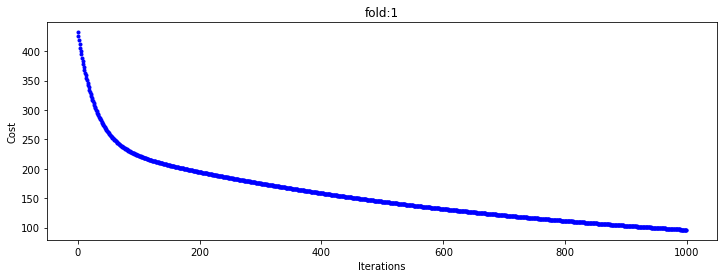

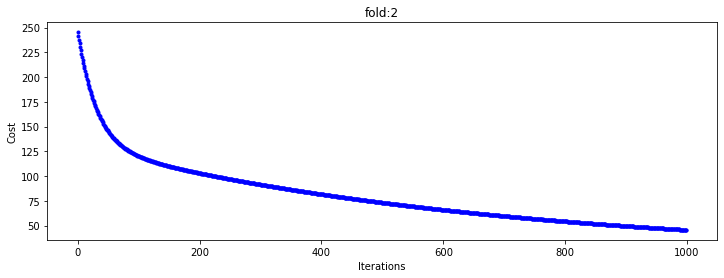

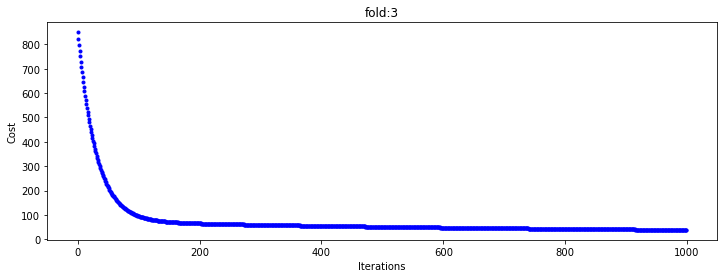

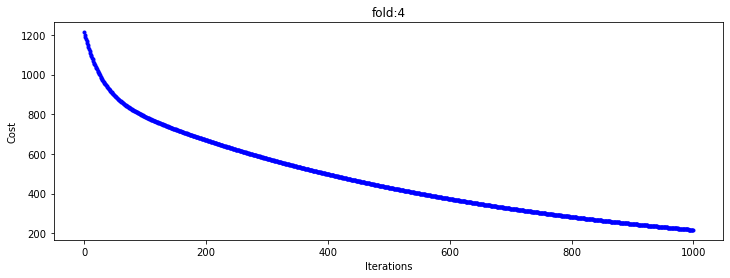

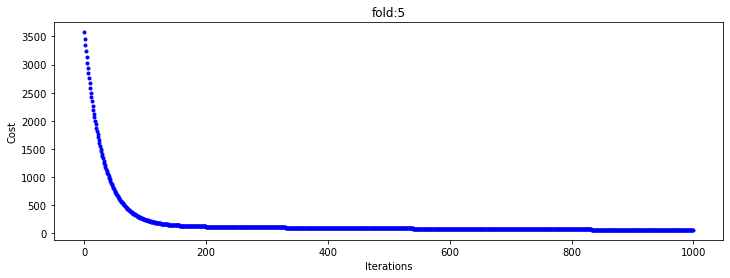

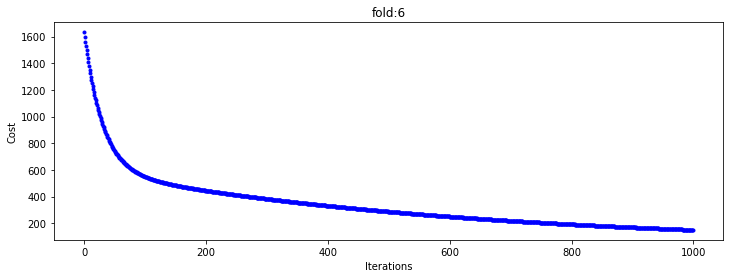

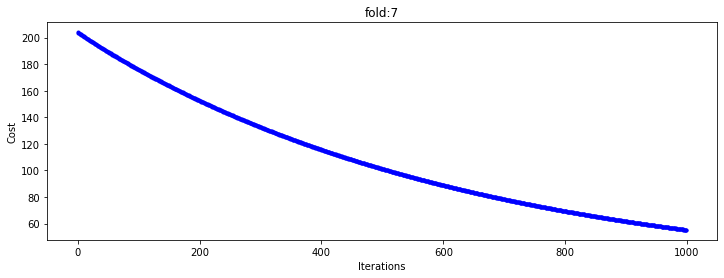

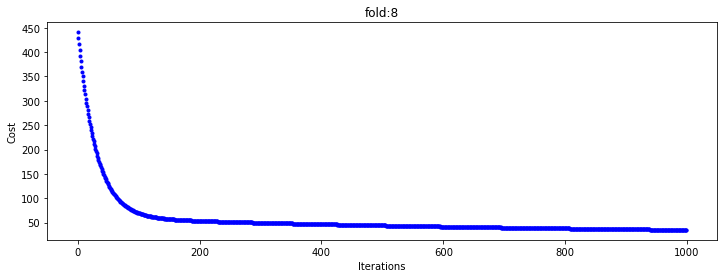

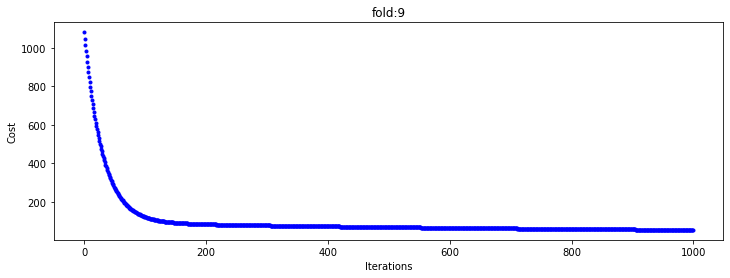

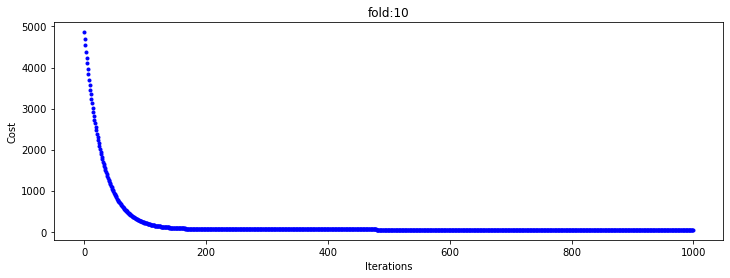

In [33]:
i=1
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index].reshape(-1,1), y[test_index].reshape(-1,1)
    X_train = np.c_[np.ones((len(X_train),1)),X_train]
    X_test = np.c_[np.ones((len(X_test),1)),X_test]
    lr = 0.01
    n_iter = 1000
    theta = np.random.randn(4, 1)
    theta, cost_history, theta_history = gradient_descent(X_train,y_train,theta,lr,n_iter)

    print('Predictions for fold:'+str(i))
    
    print('Intercept value',theta[0],'\nweight values:',theta[1:])
    
    # using the testing data and mean-square error to evaluate performance
    N = len(y_test)
    y_hat = np.dot(X_test,theta)
    mse_test = (1/N) * (np.sum(np.square(y_hat - y_test)))
    print('Mean Square Error:', round(mse_test,3),'\n')
    
    
    fig,ax = plt.subplots(figsize=(12,4))
    plt.title('fold:'+str(i))
    ax.set_ylabel('Cost')
    ax.set_xlabel('Iterations')
    _=ax.plot(range(n_iter),cost_history,'b.')
    i=i+1

### For alpha 0.001

Predictions for fold:1
Intercept value [0.3449222] 
weight values: [[ 0.52210465]
 [-0.79448595]
 [-0.03301083]]
Mean Square Error: 0.089 

Predictions for fold:2
Intercept value [-0.51372332] 
weight values: [[0.41415182]
 [0.94313222]
 [0.39542493]]
Mean Square Error: 0.471 

Predictions for fold:3
Intercept value [0.58682973] 
weight values: [[ 0.06786593]
 [-0.76594933]
 [-0.37564901]]
Mean Square Error: 0.292 

Predictions for fold:4
Intercept value [1.01313912] 
weight values: [[-0.74101108]
 [-0.5390144 ]
 [ 0.559931  ]]
Mean Square Error: 0.014 

Predictions for fold:5
Intercept value [-0.06931957] 
weight values: [[ 0.52797282]
 [-0.71476669]
 [ 1.17524689]]
Mean Square Error: 0.332 

Predictions for fold:6
Intercept value [-0.65209918] 
weight values: [[ 1.70448109]
 [-0.43595454]
 [ 1.28852944]]
Mean Square Error: 0.762 

Predictions for fold:7
Intercept value [0.14580447] 
weight values: [[ 0.54931107]
 [ 1.13615387]
 [-0.9425625 ]]
Mean Square Error: 0.052 

Predictions fo

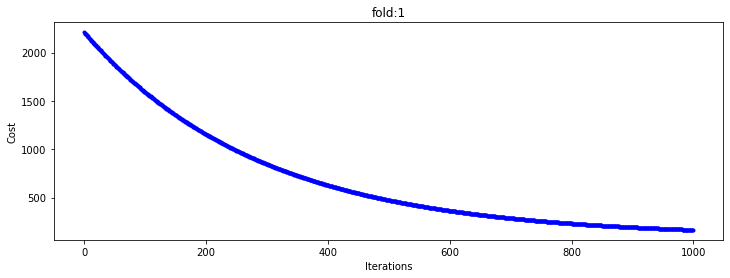

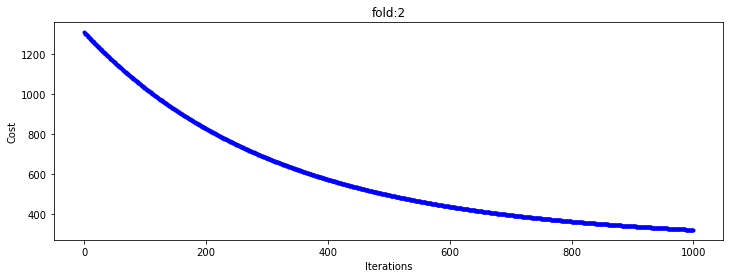

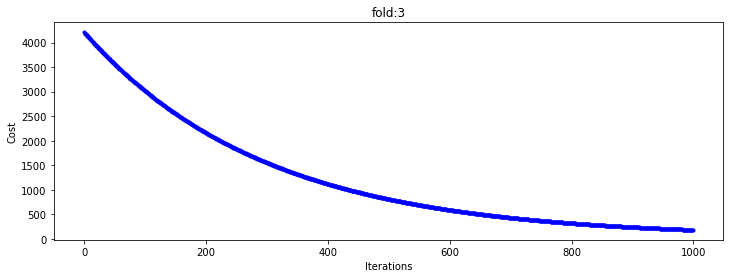

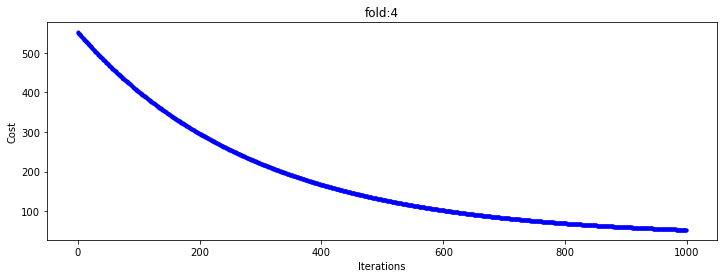

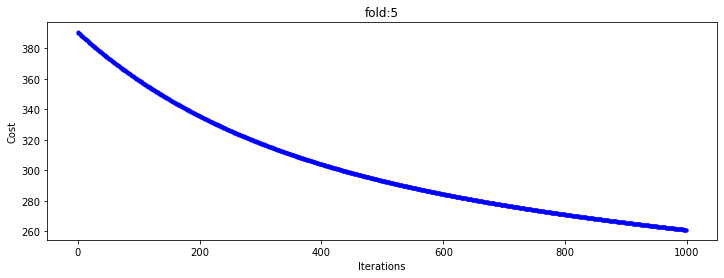

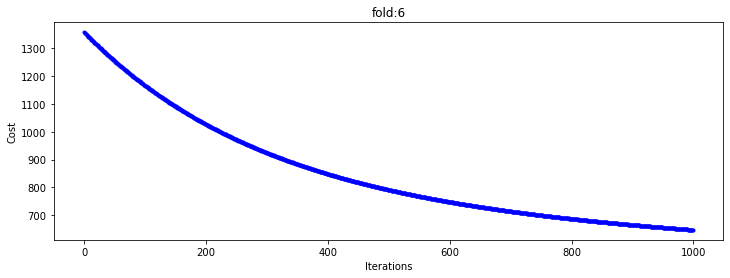

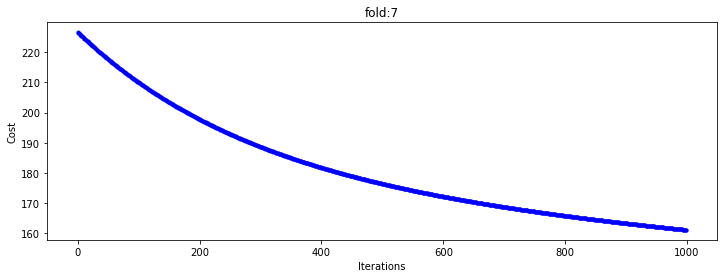

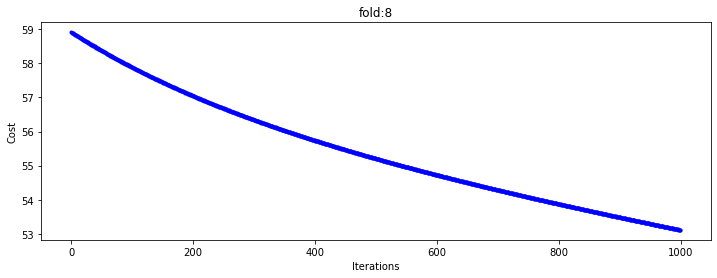

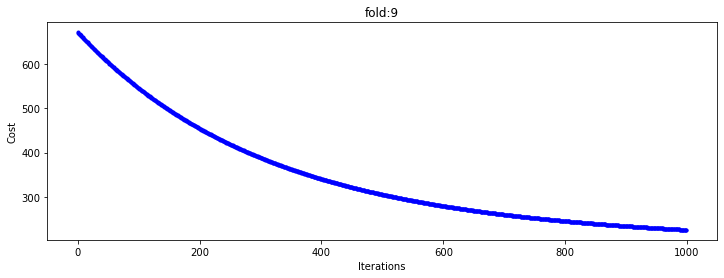

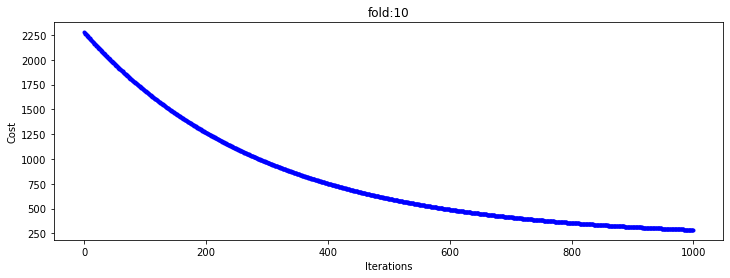

In [34]:
i=1
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index].reshape(-1,1), y[test_index].reshape(-1,1)
    X_train = np.c_[np.ones((len(X_train),1)),X_train]
    X_test = np.c_[np.ones((len(X_test),1)),X_test]
    lr = 0.001
    n_iter = 1000
    theta = np.random.randn(4, 1)
    theta, cost_history, theta_history = gradient_descent(X_train,y_train,theta,lr,n_iter)

    print('Predictions for fold:'+str(i))
    
    print('Intercept value',theta[0],'\nweight values:',theta[1:])
    
    # using the testing data and mean-square error to evaluate performance
    N = len(y_test)
    y_hat = np.dot(X_test,theta)
    mse_test = (1/N) * (np.sum(np.square(y_hat - y_test)))
    print('Mean Square Error:', round(mse_test,3),'\n')
    
    
    fig,ax = plt.subplots(figsize=(12,4))
    plt.title('fold:'+str(i))
    ax.set_ylabel('Cost')
    ax.set_xlabel('Iterations')
    _=ax.plot(range(n_iter),cost_history,'b.')
    i=i+1

### If you compare the Cost vs Iterations graph for the three aplha values i.e alpha = 0.1,0.01,0.001. It can be inferred that for aplha = 0.1, the cost decreses in a few number of iterations as compared to the other two, hence it is better if we consider alpha as 0.1 !  

### --------------------------------------------------------------------------------------------------------------------------------

### Stochastic Gradient Descent

In [35]:
def stocashtic_gradient_descent(X,y,theta,learning_rate=0.01,iterations=10):
    m = len(y)
    cost_history = np.zeros(iterations)
    for it in range(iterations):
        cost =0.0
        for i in range(m):
            rand_ind = np.random.randint(0,m)
            X_i = X[rand_ind,:].reshape(1,X.shape[1])
            y_i = y[rand_ind].reshape(1,1)
            prediction = np.dot(X_i,theta)
            theta = theta -(1/m)*learning_rate*( X_i.T.dot((prediction - y_i)))
            cost += cal_cost(theta,X_i,y_i)
        cost_history[it]  = cost
        
    return theta, cost_history

### for alpha = 0.1

Predictions for fold:1
Intercept value [0.95900014] 
weight values: [[-0.59546661]
 [ 0.00820845]
 [-0.27389113]]
Mean Square Error: 0.006 

Predictions for fold:2
Intercept value [0.9818212] 
weight values: [[-0.50283797]
 [-0.22961025]
 [-0.19217863]]
Mean Square Error: 0.013 

Predictions for fold:3
Intercept value [1.03662502] 
weight values: [[-0.56117029]
 [-0.4345265 ]
 [-0.06950609]]
Mean Square Error: 0.046 

Predictions for fold:4
Intercept value [1.00706948] 
weight values: [[-0.58631544]
 [-0.27049241]
 [-0.13584748]]
Mean Square Error: 0.027 

Predictions for fold:5
Intercept value [1.0353069] 
weight values: [[-0.51540664]
 [-0.31118906]
 [-0.1884263 ]]
Mean Square Error: 0.01 

Predictions for fold:6
Intercept value [1.01637266] 
weight values: [[-0.57093398]
 [-0.21978565]
 [-0.19546162]]
Mean Square Error: 0.022 

Predictions for fold:7
Intercept value [0.99283652] 
weight values: [[-0.59109082]
 [-0.0671786 ]
 [-0.27660827]]
Mean Square Error: 0.033 

Predictions for 

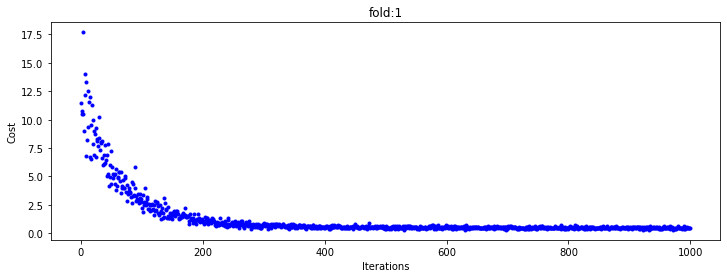

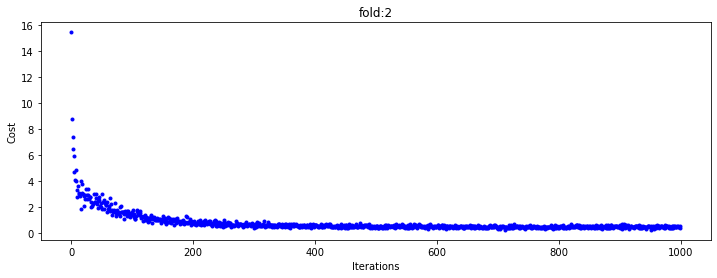

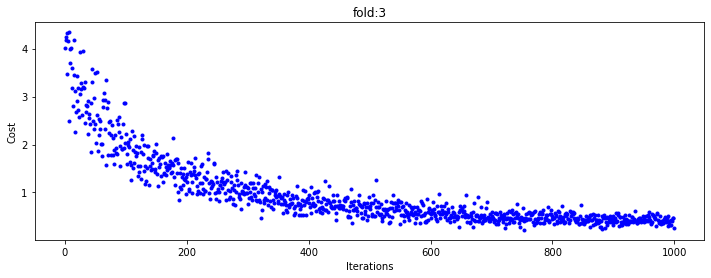

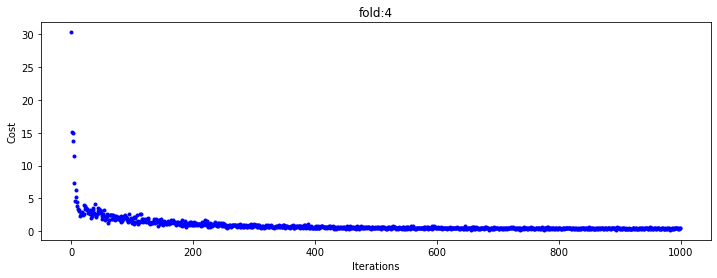

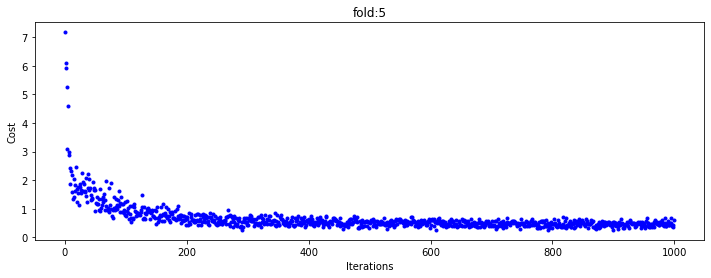

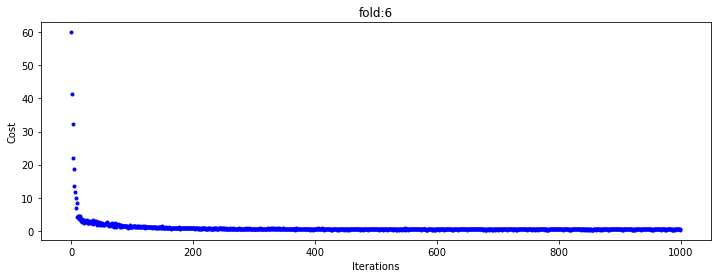

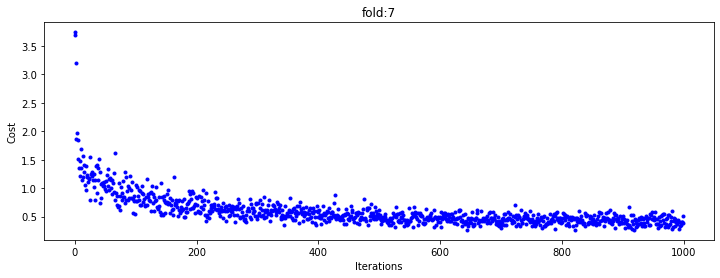

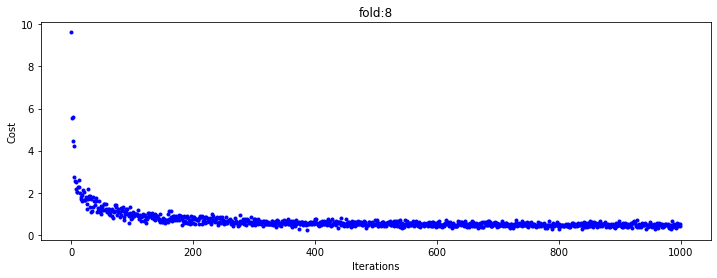

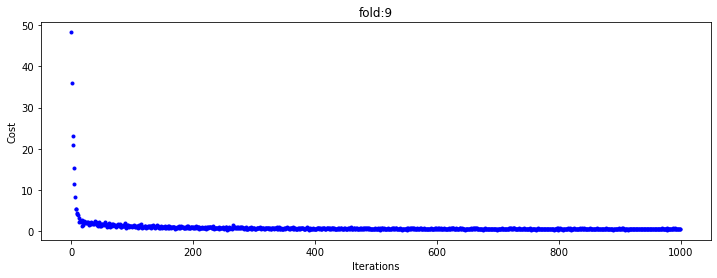

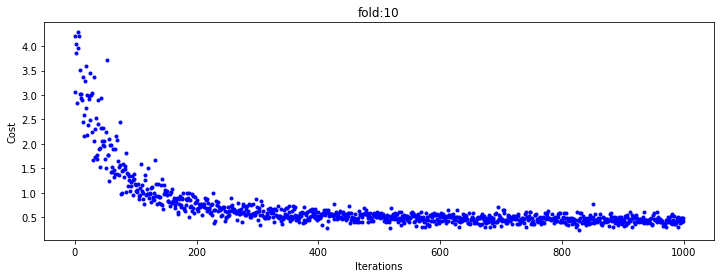

In [37]:
i=1
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index].reshape(-1,1), y[test_index].reshape(-1,1)
    X_train = np.c_[np.ones((len(X_train),1)),X_train]
    X_test = np.c_[np.ones((len(X_test),1)),X_test]
    lr = 0.1
    n_iter = 1000
    theta = np.random.randn(4, 1)
    theta, cost_history= stocashtic_gradient_descent(X_train,y_train,theta,lr,n_iter)

    print('Predictions for fold:'+str(i))
    
    print('Intercept value',theta[0],'\nweight values:',theta[1:])
    
    # using the testing data and mean-square error to evaluate performance
    N = len(y_test)
    y_hat = np.dot(X_test,theta)
    mse_test = (1/N) * (np.sum(np.square(y_hat - y_test)))
    print('Mean Square Error:', round(mse_test,3),'\n')
    
    
    fig,ax = plt.subplots(figsize=(12,4))
    plt.title('fold:'+str(i))
    ax.set_ylabel('Cost')
    ax.set_xlabel('Iterations')
    _=ax.plot(range(n_iter),cost_history,'b.')
    i=i+1

### for aplha = 0.01

Predictions for fold:1
Intercept value [0.42260032] 
weight values: [[ 0.69487504]
 [-0.27722074]
 [-0.33519078]]
Mean Square Error: 0.071 

Predictions for fold:2
Intercept value [0.37060331] 
weight values: [[-0.48967831]
 [ 0.15934321]
 [ 0.73350237]]
Mean Square Error: 0.233 

Predictions for fold:3
Intercept value [0.84635877] 
weight values: [[-0.98890601]
 [ 2.02690868]
 [-1.56742412]]
Mean Square Error: 0.219 

Predictions for fold:4
Intercept value [0.71176417] 
weight values: [[-0.13680278]
 [-0.38596416]
 [ 0.07310224]]
Mean Square Error: 0.053 

Predictions for fold:5
Intercept value [0.47933675] 
weight values: [[-0.50819792]
 [ 0.74416065]
 [-0.13251175]]
Mean Square Error: 0.058 

Predictions for fold:6
Intercept value [1.00329148] 
weight values: [[-0.95815969]
 [ 0.35735724]
 [-0.30990559]]
Mean Square Error: 0.057 

Predictions for fold:7
Intercept value [0.44333696] 
weight values: [[ 0.14474636]
 [ 0.29711423]
 [-0.36460245]]
Mean Square Error: 0.04 

Predictions fo

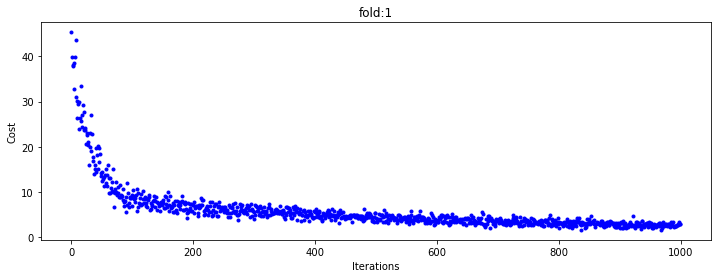

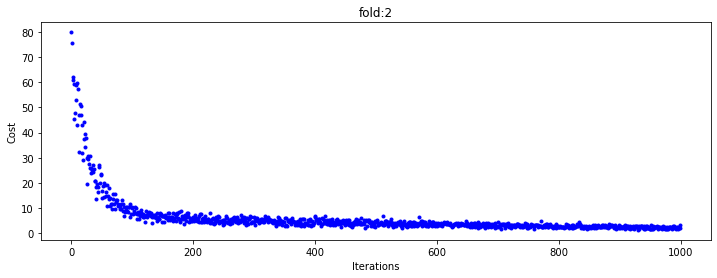

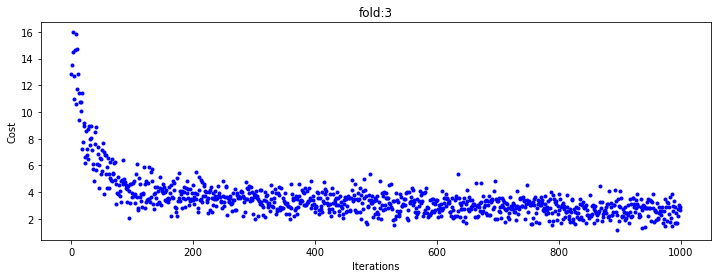

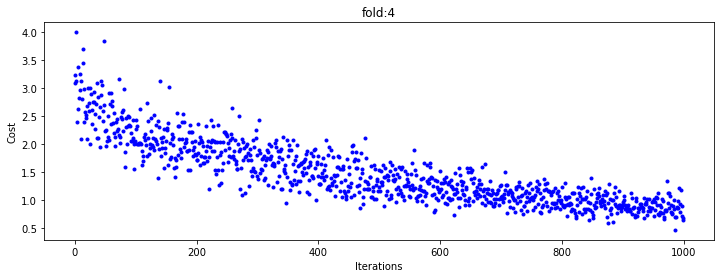

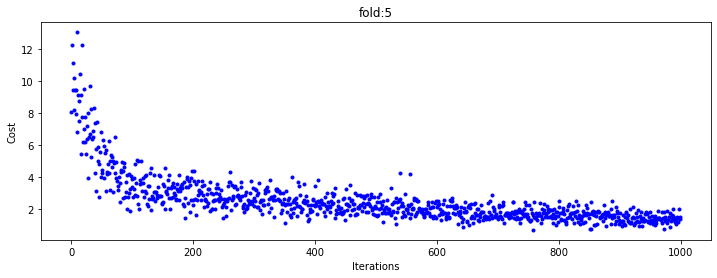

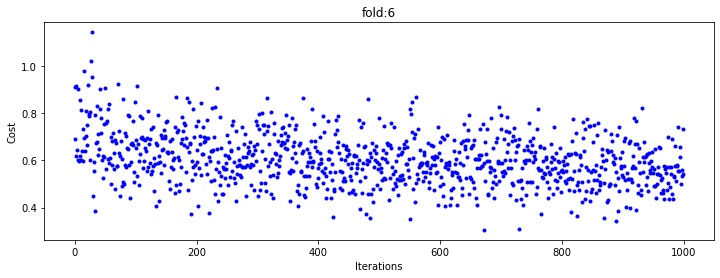

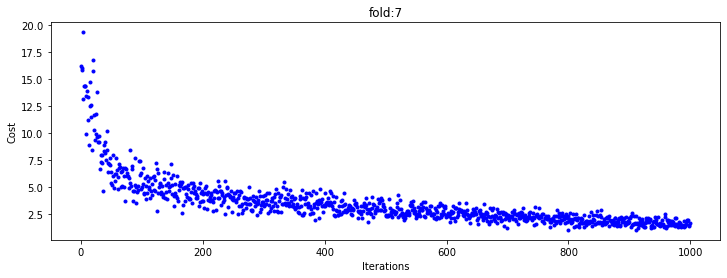

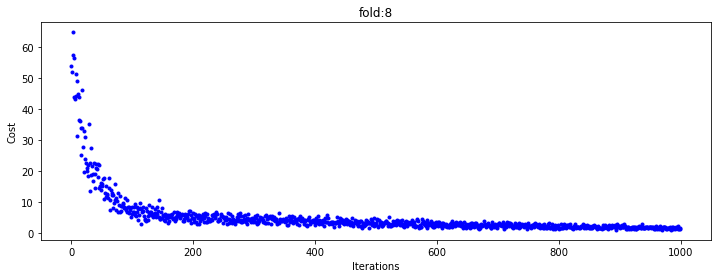

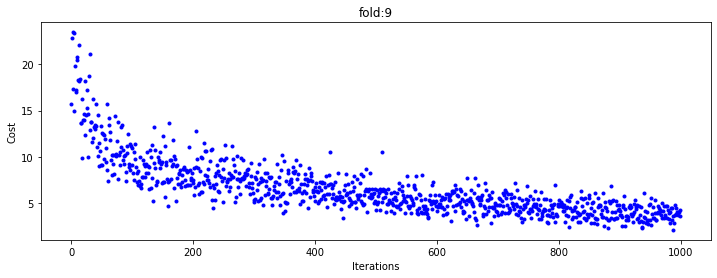

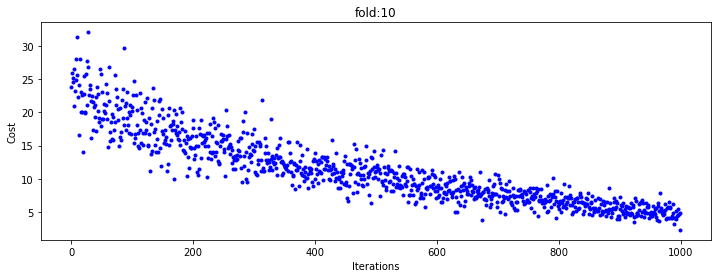

In [38]:
i=1
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index].reshape(-1,1), y[test_index].reshape(-1,1)
    X_train = np.c_[np.ones((len(X_train),1)),X_train]
    X_test = np.c_[np.ones((len(X_test),1)),X_test]
    lr = 0.01
    n_iter = 1000
    theta = np.random.randn(4, 1)
    theta, cost_history= stocashtic_gradient_descent(X_train,y_train,theta,lr,n_iter)

    print('Predictions for fold:'+str(i))
    
    print('Intercept value',theta[0],'\nweight values:',theta[1:])
    
    # using the testing data and mean-square error to evaluate performance
    N = len(y_test)
    y_hat = np.dot(X_test,theta)
    mse_test = (1/N) * (np.sum(np.square(y_hat - y_test)))
    print('Mean Square Error:', round(mse_test,3),'\n')
    
    
    fig,ax = plt.subplots(figsize=(12,4))
    plt.title('fold:'+str(i))
    ax.set_ylabel('Cost')
    ax.set_xlabel('Iterations')
    _=ax.plot(range(n_iter),cost_history,'b.')
    i=i+1

### for aplha = 0.001

Predictions for fold:1
Intercept value [-0.69959637] 
weight values: [[ 1.08111214]
 [-0.08386268]
 [ 0.89744151]]
Mean Square Error: 0.612 

Predictions for fold:2
Intercept value [-0.57886909] 
weight values: [[ 0.03668663]
 [-0.21723444]
 [ 1.28354175]]
Mean Square Error: 0.402 

Predictions for fold:3
Intercept value [0.37456991] 
weight values: [[ 1.23201782]
 [-1.08534812]
 [-0.02985613]]
Mean Square Error: 0.131 

Predictions for fold:4
Intercept value [0.86659948] 
weight values: [[ 0.28178185]
 [-0.22945307]
 [-1.06678698]]
Mean Square Error: 0.105 

Predictions for fold:5
Intercept value [0.93594365] 
weight values: [[-0.52795809]
 [-0.57731019]
 [-0.07078959]]
Mean Square Error: 0.05 

Predictions for fold:6
Intercept value [0.32558844] 
weight values: [[ 0.4147909 ]
 [-0.41747275]
 [-0.93527261]]
Mean Square Error: 0.525 

Predictions for fold:7
Intercept value [1.95767664] 
weight values: [[-0.19512519]
 [-1.42259203]
 [-1.36624957]]
Mean Square Error: 0.484 

Predictions 

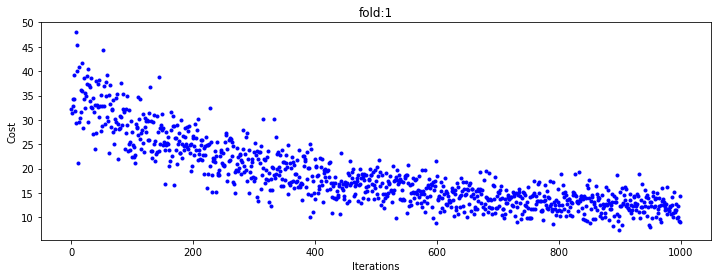

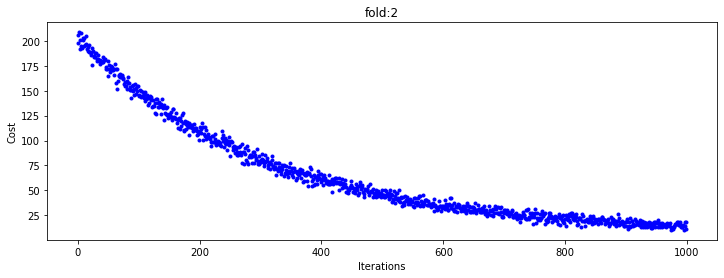

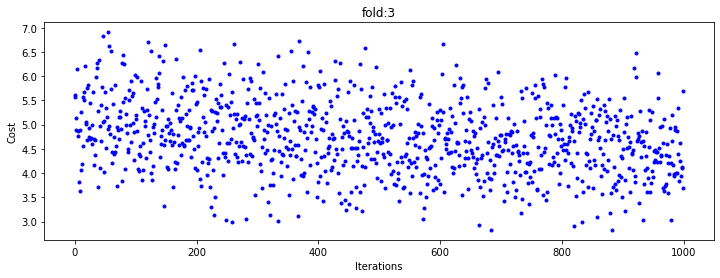

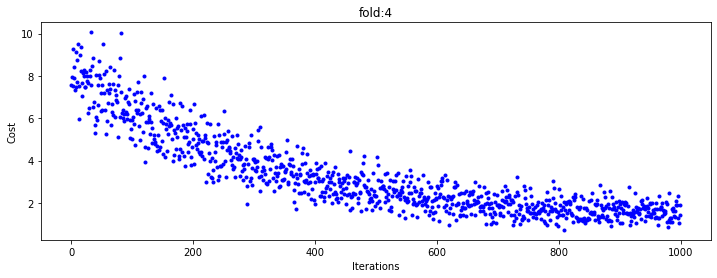

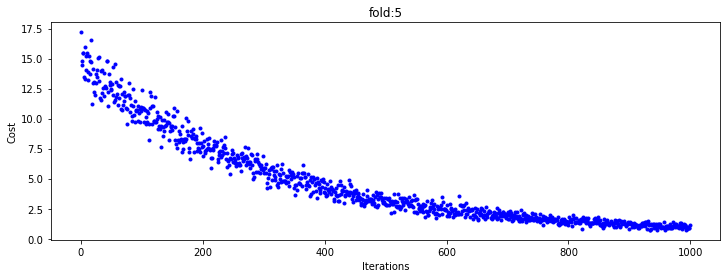

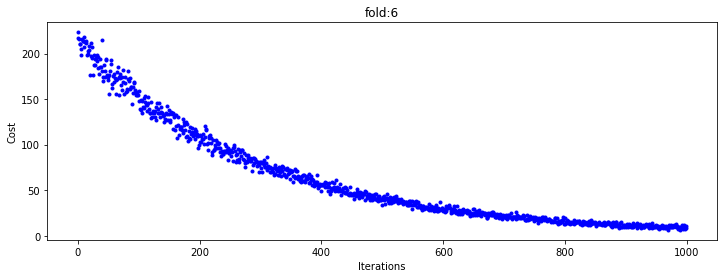

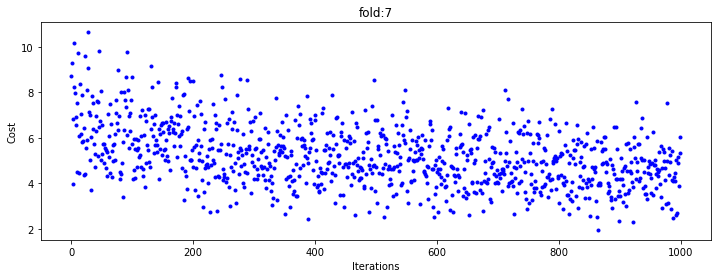

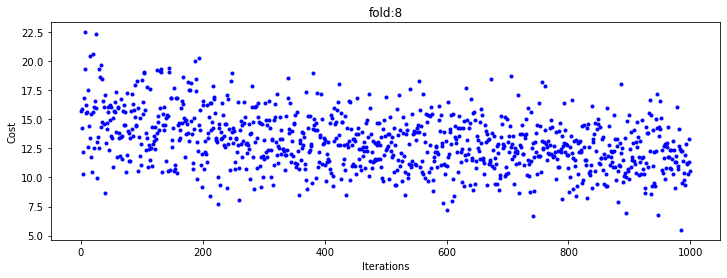

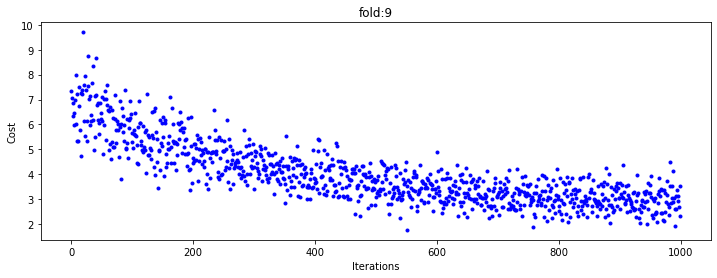

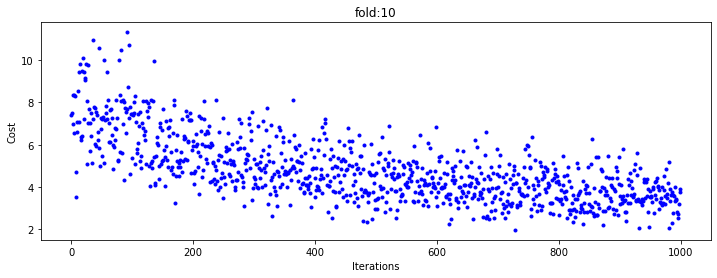

In [39]:
i=1
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index].reshape(-1,1), y[test_index].reshape(-1,1)
    X_train = np.c_[np.ones((len(X_train),1)),X_train]
    X_test = np.c_[np.ones((len(X_test),1)),X_test]
    lr = 0.001
    n_iter = 1000
    theta = np.random.randn(4, 1)
    theta, cost_history= stocashtic_gradient_descent(X_train,y_train,theta,lr,n_iter)

    print('Predictions for fold:'+str(i))
    
    print('Intercept value',theta[0],'\nweight values:',theta[1:])
    
    # using the testing data and mean-square error to evaluate performance
    N = len(y_test)
    y_hat = np.dot(X_test,theta)
    mse_test = (1/N) * (np.sum(np.square(y_hat - y_test)))
    print('Mean Square Error:', round(mse_test,3),'\n')
    
    
    fig,ax = plt.subplots(figsize=(12,4))
    plt.title('fold:'+str(i))
    ax.set_ylabel('Cost')
    ax.set_xlabel('Iterations')
    _=ax.plot(range(n_iter),cost_history,'b.')
    i=i+1

### If you compare the Cost vs Iterations graph for the three aplha values i.e alpha = 0.1,0.01,0.001. It can be inferred that for aplha = 0.1, the cost decreses in a few number of iterations as compared to the other two, hence it is better if we consider alpha as 0.1 !

### --------------------------------------------------------------------------------------------------------------------------------

### Mini Batch Gradient Descent

In [41]:
def minibatch_gradient_descent(X,y,theta,learning_rate=0.01,iterations=100,batch_size =20):
    m = len(y)
    cost_history = np.zeros(iterations)
    n_batches = int(m/batch_size)
    
    for it in range(iterations):
        cost =0.0
        indices = np.random.permutation(m)
        X = X[indices]
        y = y[indices]
        for i in range(0,m,batch_size):
            X_i = X[i:i+batch_size]
            y_i = y[i:i+batch_size]
            prediction = np.dot(X_i,theta)
            theta = theta -(1/m)*learning_rate*(X_i.T.dot((prediction - y_i)))
            cost += cal_cost(theta,X_i,y_i)
        cost_history[it]  = cost
        
    return theta, cost_history

### batch size 5 and aplha 0.1

Predictions for fold:1
Intercept value [0.98443293] 
weight values: [[-0.46387471]
 [-0.1948364 ]
 [-0.28409872]]
Mean Square Error: 0.006 

Predictions for fold:2
Intercept value [0.96604399] 
weight values: [[-0.53957231]
 [-0.09775154]
 [-0.24064943]]
Mean Square Error: 0.013 

Predictions for fold:3
Intercept value [0.99103116] 
weight values: [[-0.65403342]
 [-0.10450207]
 [-0.19234196]]
Mean Square Error: 0.052 

Predictions for fold:4
Intercept value [1.0019602] 
weight values: [[-0.53977976]
 [-0.27613268]
 [-0.17719202]]
Mean Square Error: 0.028 

Predictions for fold:5
Intercept value [1.00186812] 
weight values: [[-0.54536334]
 [-0.2026232 ]
 [-0.23584603]]
Mean Square Error: 0.009 

Predictions for fold:6
Intercept value [0.97567278] 
weight values: [[-0.59144101]
 [ 0.07065124]
 [-0.38169631]]
Mean Square Error: 0.033 

Predictions for fold:7
Intercept value [1.01055181] 
weight values: [[-0.59193132]
 [-0.2115274 ]
 [-0.17070482]]
Mean Square Error: 0.041 

Predictions fo

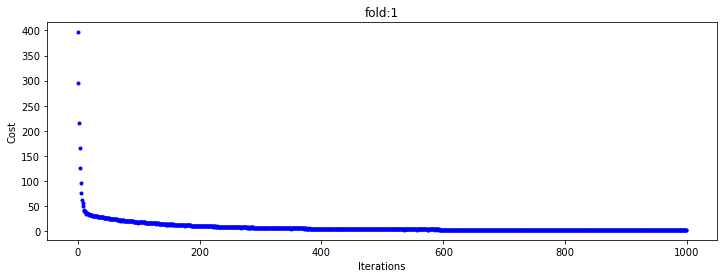

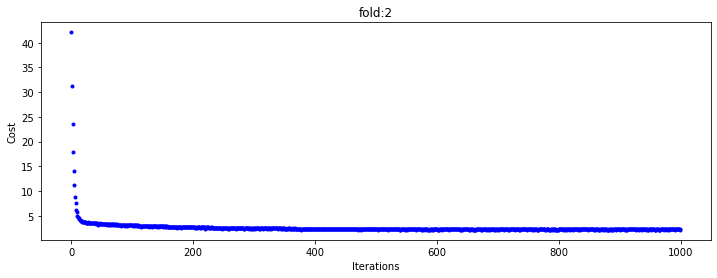

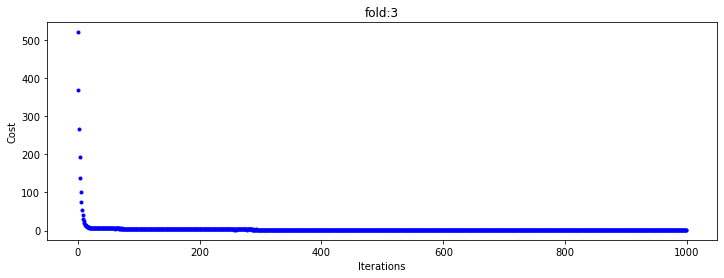

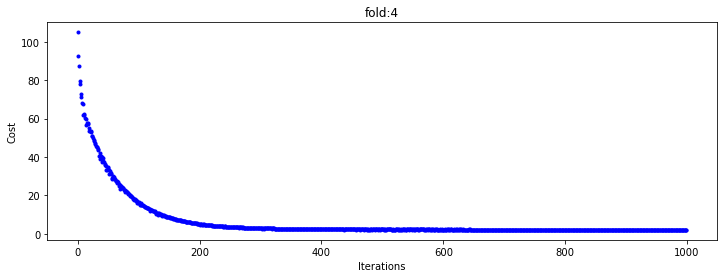

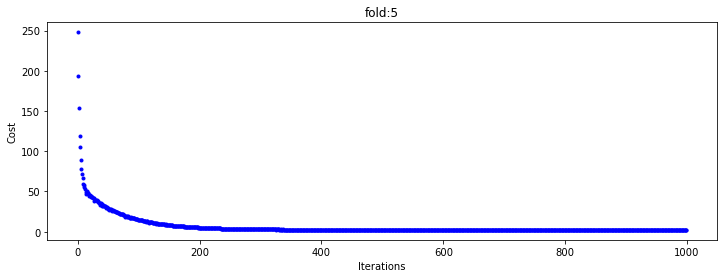

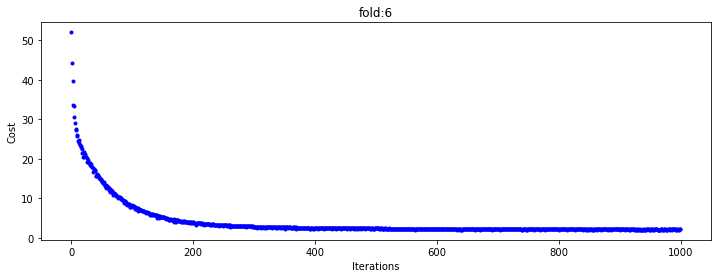

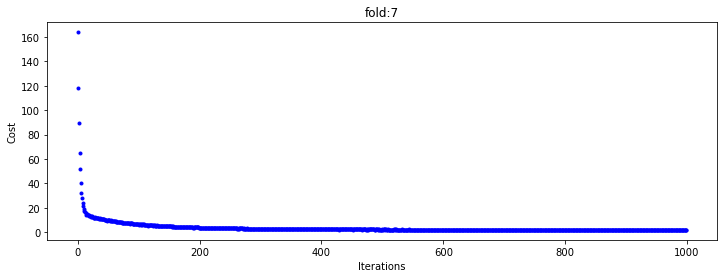

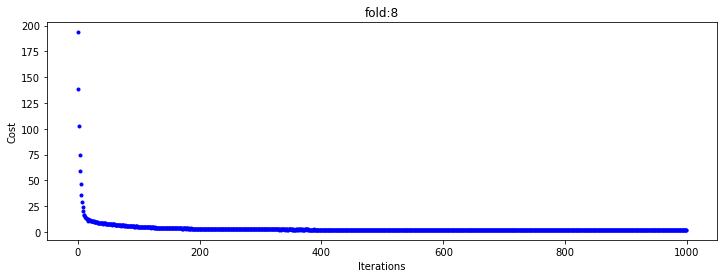

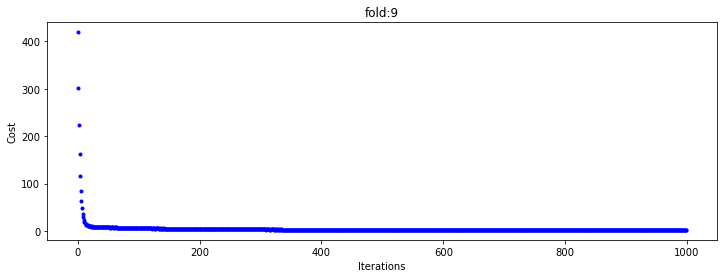

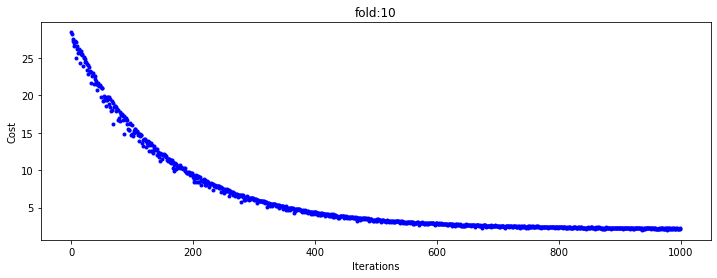

In [48]:
i=1
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index].reshape(-1,1), y[test_index].reshape(-1,1)
    X_train = np.c_[np.ones((len(X_train),1)),X_train]
    X_test = np.c_[np.ones((len(X_test),1)),X_test]
    lr = 0.1
    n_iter = 1000
    batch_size=5
    theta = np.random.randn(4, 1)
    theta, cost_history= minibatch_gradient_descent(X_train,y_train,theta,lr,n_iter,batch_size)

    print('Predictions for fold:'+str(i))
    
    print('Intercept value',theta[0],'\nweight values:',theta[1:])
    
    # using the testing data and mean-square error to evaluate performance
    N = len(y_test)
    y_hat = np.dot(X_test,theta)
    mse_test = (1/N) * (np.sum(np.square(y_hat - y_test)))
    print('Mean Square Error:', round(mse_test,3),'\n')
    
    
    fig,ax = plt.subplots(figsize=(12,4))
    plt.title('fold:'+str(i))
    ax.set_ylabel('Cost')
    ax.set_xlabel('Iterations')
    _=ax.plot(range(n_iter),cost_history,'b.')
    i=i+1

### batch size 10 and aplha 0.1

Predictions for fold:1
Intercept value [1.01968038] 
weight values: [[-0.47671516]
 [-0.39154183]
 [-0.14541154]]
Mean Square Error: 0.008 

Predictions for fold:2
Intercept value [0.93866799] 
weight values: [[-0.58091496]
 [ 0.09765786]
 [-0.33248252]]
Mean Square Error: 0.015 

Predictions for fold:3
Intercept value [0.96516043] 
weight values: [[-0.64533883]
 [ 0.04793948]
 [-0.29679899]]
Mean Square Error: 0.055 

Predictions for fold:4
Intercept value [0.98511988] 
weight values: [[-0.53236795]
 [-0.16259325]
 [-0.26163353]]
Mean Square Error: 0.027 

Predictions for fold:5
Intercept value [1.01000109] 
weight values: [[-0.6055012 ]
 [-0.22227397]
 [-0.16536472]]
Mean Square Error: 0.008 

Predictions for fold:6
Intercept value [0.98366766] 
weight values: [[-0.55714154]
 [-0.01123159]
 [-0.35399222]]
Mean Square Error: 0.029 

Predictions for fold:7
Intercept value [1.03189296] 
weight values: [[-0.53034155]
 [-0.35605121]
 [-0.13815997]]
Mean Square Error: 0.05 

Predictions fo

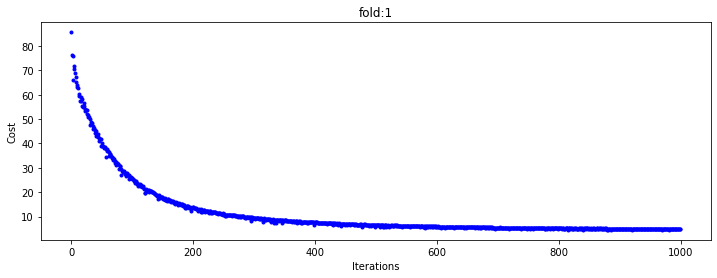

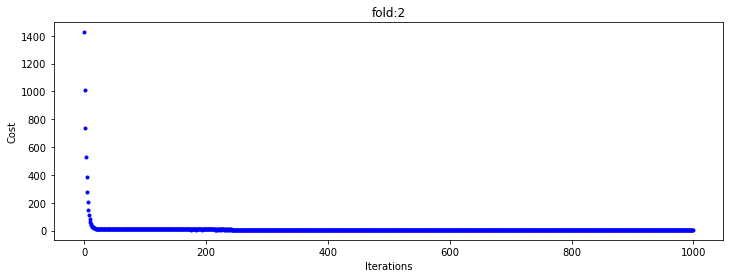

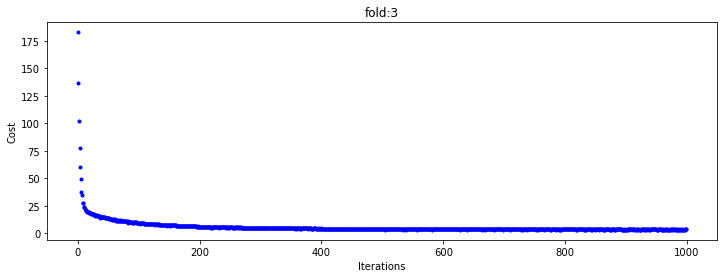

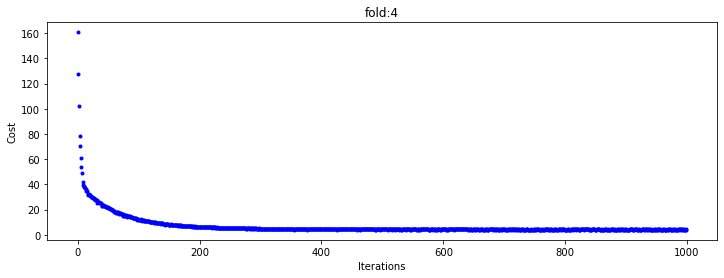

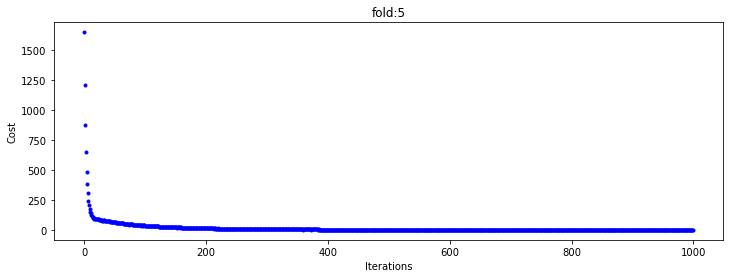

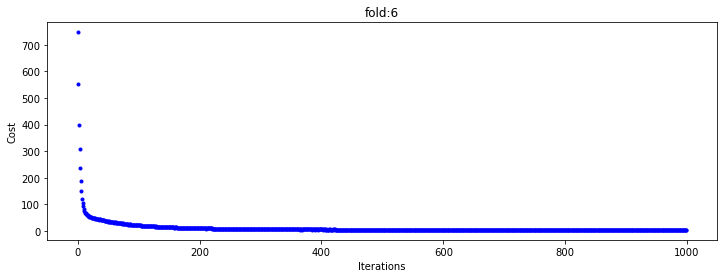

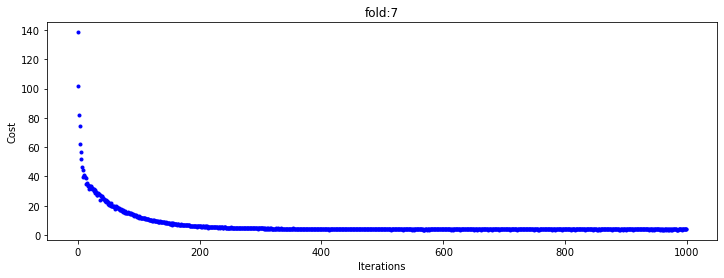

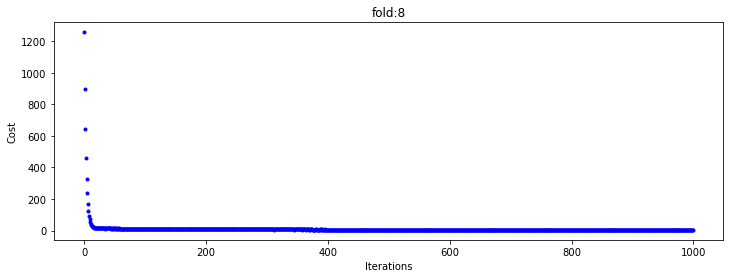

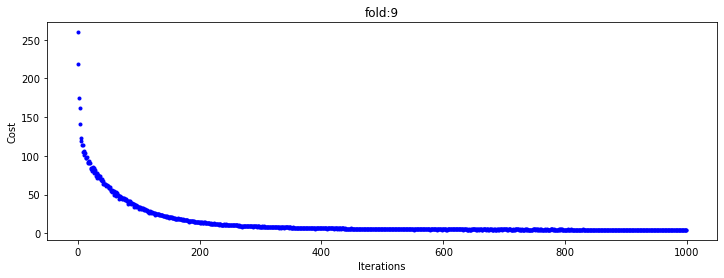

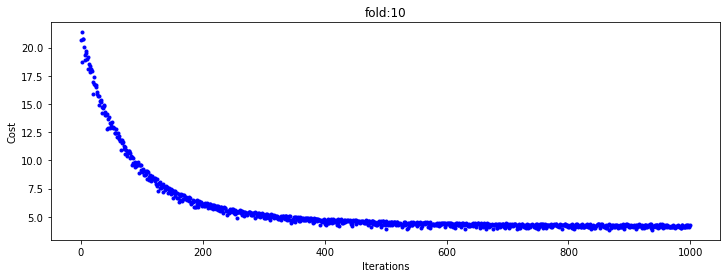

In [50]:
i=1
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index].reshape(-1,1), y[test_index].reshape(-1,1)
    X_train = np.c_[np.ones((len(X_train),1)),X_train]
    X_test = np.c_[np.ones((len(X_test),1)),X_test]
    lr = 0.1
    n_iter = 1000
    batch_size=10
    theta = np.random.randn(4, 1)
    theta, cost_history= minibatch_gradient_descent(X_train,y_train,theta,lr,n_iter,batch_size)

    print('Predictions for fold:'+str(i))
    
    print('Intercept value',theta[0],'\nweight values:',theta[1:])
    
    # using the testing data and mean-square error to evaluate performance
    N = len(y_test)
    y_hat = np.dot(X_test,theta)
    mse_test = (1/N) * (np.sum(np.square(y_hat - y_test)))
    print('Mean Square Error:', round(mse_test,3),'\n')
    
    
    fig,ax = plt.subplots(figsize=(12,4))
    plt.title('fold:'+str(i))
    ax.set_ylabel('Cost')
    ax.set_xlabel('Iterations')
    _=ax.plot(range(n_iter),cost_history,'b.')
    i=i+1

### batch size 20 and aplha is 0.1

Predictions for fold:1
Intercept value [1.00378324] 
weight values: [[-0.54603796]
 [-0.29433132]
 [-0.13629268]]
Mean Square Error: 0.008 

Predictions for fold:2
Intercept value [1.0262422] 
weight values: [[-0.50190799]
 [-0.51142845]
 [ 0.00392879]]
Mean Square Error: 0.016 

Predictions for fold:3
Intercept value [0.93833413] 
weight values: [[-0.57238371]
 [ 0.16409009]
 [-0.4327085 ]]
Mean Square Error: 0.059 

Predictions for fold:4
Intercept value [0.98970051] 
weight values: [[-0.48097532]
 [-0.22716878]
 [-0.26445677]]
Mean Square Error: 0.029 

Predictions for fold:5
Intercept value [1.00722308] 
weight values: [[-0.51902785]
 [-0.24337478]
 [-0.23749367]]
Mean Square Error: 0.011 

Predictions for fold:6
Intercept value [0.98478965] 
weight values: [[-0.62547883]
 [ 0.04156612]
 [-0.33226949]]
Mean Square Error: 0.032 

Predictions for fold:7
Intercept value [0.99927452] 
weight values: [[-0.59461202]
 [-0.14455635]
 [-0.21234817]]
Mean Square Error: 0.037 

Predictions fo

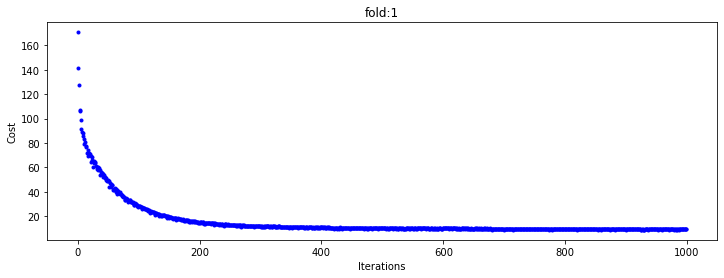

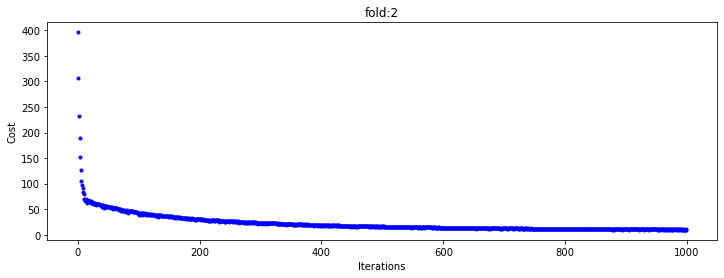

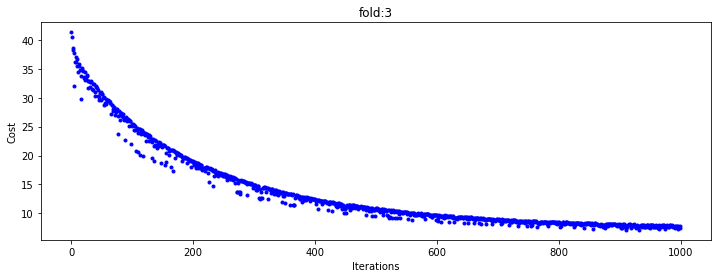

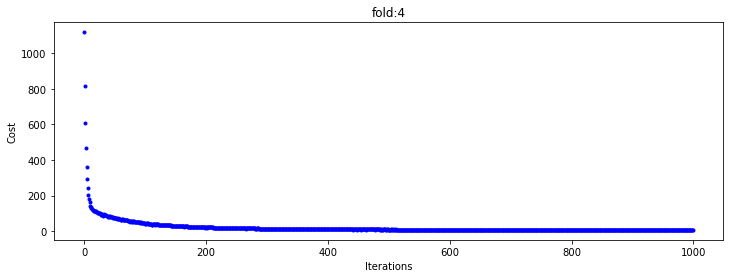

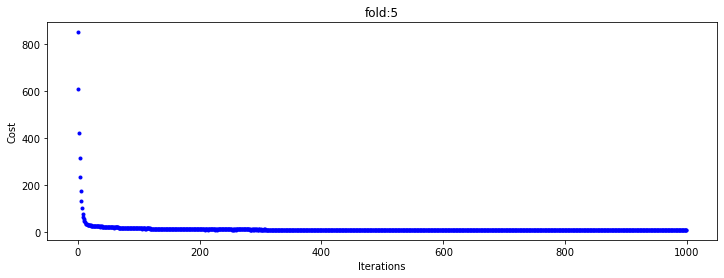

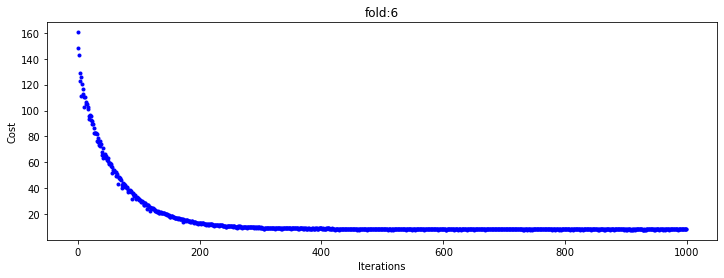

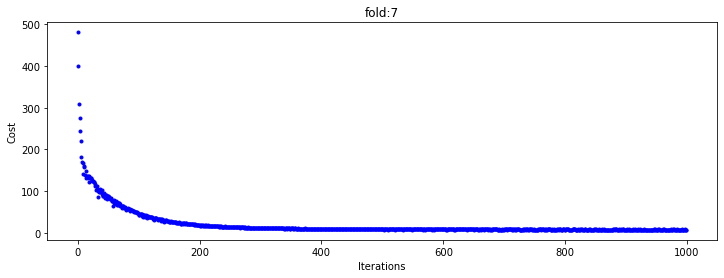

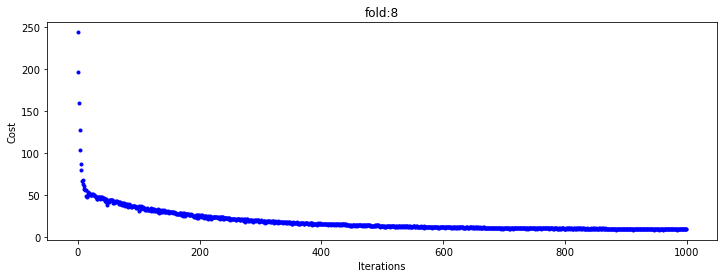

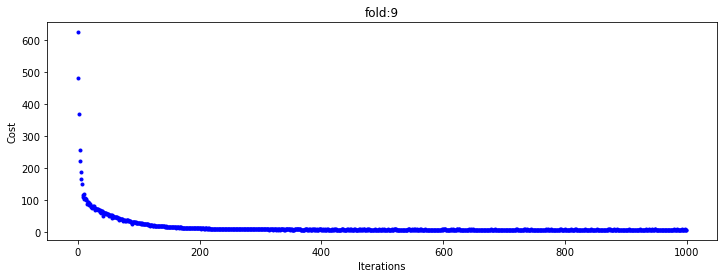

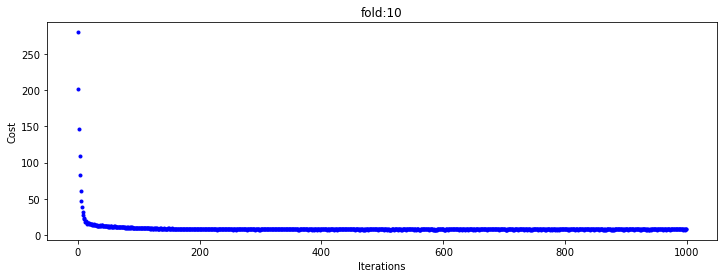

In [54]:
i=1
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index].reshape(-1,1), y[test_index].reshape(-1,1)
    X_train = np.c_[np.ones((len(X_train),1)),X_train]
    X_test = np.c_[np.ones((len(X_test),1)),X_test]
    lr = 0.1
    n_iter = 1000
    batch_size=20
    theta = np.random.randn(4, 1)
    theta, cost_history= minibatch_gradient_descent(X_train,y_train,theta,lr,n_iter,batch_size)

    print('Predictions for fold:'+str(i))
    
    print('Intercept value',theta[0],'\nweight values:',theta[1:])
    
    # using the testing data and mean-square error to evaluate performance
    N = len(y_test)
    y_hat = np.dot(X_test,theta)
    mse_test = (1/N) * (np.sum(np.square(y_hat - y_test)))
    print('Mean Square Error:', round(mse_test,3),'\n')
    
    
    fig,ax = plt.subplots(figsize=(12,4))
    plt.title('fold:'+str(i))
    ax.set_ylabel('Cost')
    ax.set_xlabel('Iterations')
    _=ax.plot(range(n_iter),cost_history,'b.')
    i=i+1

### --------------------------------------------------------------------------------------------------------------------------------

### Here as the batch size increases there is not much information about the convergence of the cost function, as it performs almost  the same. Thus, we can go with a higher batch size in this case as it will take less time to compute the results, thus we can take batch size as 20 in this case or even a higher value than 20 if it gives the similar results for cost vs iteration graph.

### In terms of comparing the 3 G.D approaches, batch will most likely give us the optimal minumim since it traverses the entire training set at once, but it will take a lot of time if the training examples are large. Also, in stochastic descent, the variance is high as the values are chosen randomly one at a time from the training set thus it becomes a challenge. Hence, it's better to perform mini-batch as it will execute in less time as compared to batch and also not give much variance as in the case of stochastic descent. 